<a target="_blank" href="https://colab.research.google.com/github/sriniraghunathan/reion_ksz_2pt_4pt/blob/main/simple_4pt_estimator.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Trispectrum estimator using a Quadratic estimator

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, glob, healpy as H, os, sys
sys.path.append('modules/')
import ksz_4pt_flatsky_tools
from pylab import *

In [3]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'

In [10]:
#map specs
reso_arcmin = 0.5
reso_rad = np.radians(reso_arcmin/60.)
ny, nx = 1560, 1560
lmax = 8000
els = np.arange( lmax )

#specs for 4-pt calculations
binsize = 50
lmax_bigK = 1000
add_circular_mask_for_big_K = True

#data or sim location
##which_ksz_sim = 'amber'
##which_ksz_sim = '21cmfast'
which_ksz_sim_dic = {'amber': 'AMBER', '21cmfast': '21cmFAST'}
mapparams = [ny, nx, reso_arcmin, reso_arcmin]
mask_deg = 3.
    
#filter stuff
remove_mean = True
##filter_lmin_lmax_arr = [(3000., 3500.), (3500., 4000.), (4000., 4500.), (4500., 5000.)]
filter_lmin_lmax_arr = [(3000., 3500.)]#, (3500., 4000.), (4000., 4500.), (4500., 5000.)]
    
#debug options
show_plot = False #True
fsval = 14
    

In [5]:
lx, ly = ksz_4pt_flatsky_tools.get_lxly(mapparams)

#smoothing filter for visualisation
gauss_beam_fwhm_deg = 0.5
bl_for_smoothing = H.gauss_beam(np.radians(gauss_beam_fwhm_deg), 10000)
bl_2D_for_smoothing = ksz_4pt_flatsky_tools.cl_to_cl2d(np.arange(len(bl_for_smoothing)), bl_for_smoothing, mapparams)

if show_plot:
    subplot(111); imshow( np.fft.fftshift(bl_2D_for_smoothing), extent = [np.min(lx), np.max(lx), np.min(ly), np.max(ly)]); colorbar(); 
    xlabel(r'$\ell_{x}$', fontsize = fsval); #ylabel(r'$\ell_{y}$', fontsize = fsval); 
    title(r'Gaussian FWHM = %g degrees for smoothing' %(gauss_beam_fwhm_deg), fontsize = fsval-4)
    xlim(-axlim, axlim); ylim(-axlim, axlim); 
    show()
    

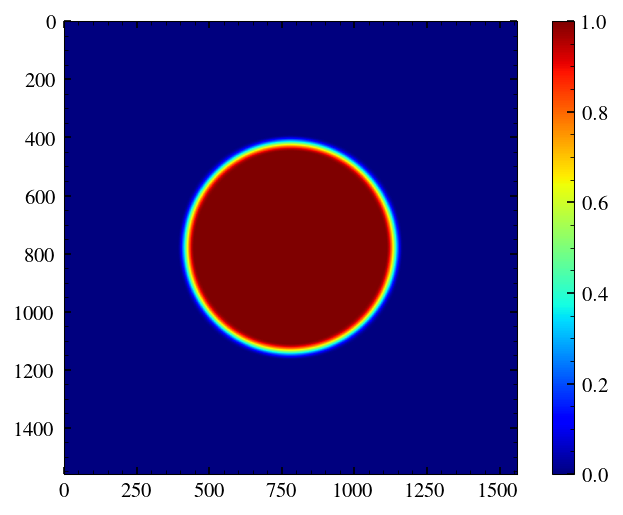

In [33]:
'''
#mask
mask_circular = ksz_4pt_flatsky_tools.get_circular_mask(ny, nx, angres_am = reso_arcmin, circular_mask_deg = circular_mask_deg)
imshow(mask_circular); colorbar(); show()
'''

#mask
mask = ksz_4pt_flatsky_tools.get_mask(ny, nx, angres_am = reso_arcmin, mask_deg = mask_deg, circle_or_square = 'circle')
#mask = ksz_4pt_flatsky_tools.get_mask(ny, nx, angres_am = reso_arcmin, mask_deg = mask_deg)
imshow(mask); colorbar(); show()

In [41]:
master_result_dict = {}
for which_ksz_sim_iter, which_ksz_sim in enumerate( which_ksz_sim_dic ):
    
    print('\nkSZ sim = %s' %(which_ksz_sim))

    if which_ksz_sim == 'amber':
        amber_ksz_2pt_dic = {}
        reqd_Az_str = '_Az2_'
        sim_fd = 'amber/Nm1d512_box1000_ionfrac0.05-0.95_z5-40-0.2_nside8192/for_sim_comparisons_ksz/seed1/'
    elif which_ksz_sim == '21cmfast':
        nside = 8192
        ra0, dec0 = 0., 90.
        boxsize = ny
        sim_fd = '21cmFAST/maps/'
        use_flat_sky_maps_for_21cmfast = False #True
        mapname_zmid_deltaz_mapper_dict = {'HII_20_BUBBLE_15_Tvir_43': {'z_mid': 8.09399, 'delta_z': 6.07768}, 
                                           'HII_50_BUBBLE_15_Tvir_469': {'z_mid': 8.46139, 'delta_z': 4.97214}, 
                                           'HII_80_BUBBLE_15_Tvir_469': {'z_mid': 9.44614, 'delta_z': 4.94372}, 
                                           'HII_95_BUBBLE_18_Tvir_5': {'z_mid': 8.46139, 'delta_z': 4.32245}, 
                                           'HII_96_BUBBLE_18_Tvir_52': {'z_mid': 7.74086, 'delta_z': 4.36283}, 
                                          }
        
    #get map list
    if which_ksz_sim == 'amber':
        maplist = sorted( glob.glob( '%s/*%s*/cmb/map_ksz_nside=8192.npy' %(sim_fd, reqd_Az_str)) )
    elif which_ksz_sim == '21cmfast':
        if use_flat_sky_maps_for_21cmfast:
            maplist = sorted( glob.glob( '%s/flat_maps_r8907/ksz_flat_map_z_*.dat' %(sim_fd)) )
        else:
            maplist = sorted( glob.glob( '%s/ksz_map_8192_z*.dat' %(sim_fd)) )
    print( '\n\tTotal maps = %s\n' %(len(maplist)) )#; sys.exit()

    #loop over map and get the 4-pt
    result_dict = {}
    for mapname in maplist:

        if which_ksz_sim == 'amber':
            z_re_val = float( re.findall('zre[0-9.0-9]*', mapname)[0].replace('zre', '') )
            delta_z_val = float( re.findall('Dz[0-9.0-9]*', mapname)[0].replace('Dz', '') ) 
        elif which_ksz_sim == '21cmfast':
            maptype_str = re.findall('HII_[0-9]*_BUBBLE_[0-9]*_Tvir_[0-9]*', mapname)[0]
            z_re_val = mapname_zmid_deltaz_mapper_dict[maptype_str]['z_mid']
            delta_z_val = mapname_zmid_deltaz_mapper_dict[maptype_str]['delta_z']
            ##print( maptype_str, z_re_val, delta_z_val )
            
        keyname = (z_re_val, delta_z_val)
        print( '\t z_mid = %s, delta_z_90 = %s' %(z_re_val, delta_z_val) )
        result_dict[keyname] = {}
        ##########################################################################################
        if (1): #AMBER kSZ power spectrum
            if which_ksz_sim == 'amber':
                tcmb = 2.73
                dummy_fd = '/'.join(mapname.split('/')[:-1])
                tmp_amber_cl_ksz_fname = '%s/cl_ksz.txt' %(dummy_fd)                                                      
                tmp_el, tmp_cl_ksz = np.loadtxt(tmp_amber_cl_ksz_fname, unpack = True, skiprows = 1)
                tmp_cl_ksz = tmp_cl_ksz * 1e12 * tcmb**2.
                tmp_dl_fac = tmp_el * (tmp_el+1)/2/np.pi
                amber_ksz_2pt_dic[keyname] = [tmp_el, tmp_cl_ksz]
        ##########################################################################################
        #read map
        if which_ksz_sim == 'amber': #read flatsky map
            tmap = np.load( mapname, allow_pickle = True ) * mask
        elif which_ksz_sim == '21cmfast': #convert healpix to flatsky map
            if use_flat_sky_maps_for_21cmfast:            
                print(mapname); sys.exit()
            else:
                npix = H.nside2npix(nside)
                hmap = np.zeros( npix )
                pix_ind_arr, pix_val_arr = np.loadtxt(mapname, unpack = True)

                npix = H.nside2npix(nside)
                hmap = np.zeros( npix )
                pix_ind_arr, pix_val_arr = np.loadtxt(mapname, unpack = True)
                pix_ind_arr = pix_ind_arr.astype(int)
                hmap[pix_ind_arr] = pix_val_arr * 1e6
                ##H.mollview(hmap); show()

                tmap = H.gnomview(hmap, rot=[ra0, dec0], xsize=boxsize, reso=reso_arcmin, return_projected_map=True); close()
            tmap = np.asarray( tmap ) - np.mean(tmap)
            tmap = tmap * mask
            ##imshow(tmap); colorbar(); show(); sys.exit()
            
        tmap_unfil = np.copy( tmap )
        ##########################################################################################
        ksz_4pt_dict = {}
        for filter_lmin_lmax in filter_lmin_lmax_arr:
            
            lmin_for_filter, lmax_for_filter = filter_lmin_lmax
            print('\t\t(lmin, lmax) = (%g, %g)' %(lmin_for_filter, lmax_for_filter))

            
            #get filter
            wl_1d, wl_2D = ksz_4pt_flatsky_tools.get_filter(els, lmin_for_filter = lmin_for_filter, lmax_for_filter = lmax_for_filter, mapparams = mapparams)
            '''
            if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2):
                wl2_1d, wl2_2D = ksz_4pt_flatsky_tools.get_filter(els, lmin_for_filter = lmin_for_filter2, lmax_for_filter = lmax_for_filter2, mapparams = mapparams)
            '''

            if show_plot:
                clf()        
                plot(els, wl_1d); xlabel(r'Multipole $\ell$', fontsize = fsval); ylabel(r'Filter $w_{\ell}$', fontsize = fsval); 
                title(r'Filter $\ell \in [%g, %g]$' %(lmin_for_filter, lmax_for_filter), fontsize = fsval)
                show()

                clf()
                axlim = 6000.
                subplot(111); imshow( np.fft.fftshift(wl_2D), extent = [np.min(lx), np.max(lx), np.min(ly), np.max(ly)]); colorbar(); 
                xlabel(r'$\ell_{x}$', fontsize = fsval); ylabel(r'$\ell_{y}$', fontsize = fsval); 
                title(r'Filter $\ell \in [%g, %g]$' %(lmin_for_filter, lmax_for_filter), fontsize = fsval-4)
                xlim(-axlim, axlim); ylim(-axlim, axlim); 
                

            ##########################################################################################
            #filter maps
            tmap1 = np.fft.ifft2( np.fft.fft2( tmap ) * wl_2D ).real
            if (0):##(lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2):
                tmap2 = np.fft.ifft2( np.fft.fft2( tmap ) * w2_2D ).real
            else:
                tmap2 = np.copy( tmap1 )
                
            ##imshow(tmap1); colorbar(); show(); sys.exit()

            #get power spectrum
            el_2pt, cl_m1_unfiltered = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap_unfil, binsize = binsize, maxbin = lmax, mask = mask)
            el_2pt, cl_m1 = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap1, binsize = binsize, maxbin = lmax, mask = mask)

            #get kbar
            fbar = ksz_4pt_flatsky_tools.get_kbar(els, wl_1d)
            tmp_cl_m1_ip = np.interp(els, el_2pt, cl_m1)
            kbar = ksz_4pt_flatsky_tools.get_kbar(els, wl_1d, tmpcls_signal = tmp_cl_m1_ip, filter_only = False)
            if (1):
                tmplinds = np.where( (el_2pt>=lmin_for_filter) & ((el_2pt<=lmax_for_filter)))
                dl_fac = el_2pt * (el_2pt+1)/2/np.pi
                dl_m1 = cl_m1 * dl_fac
                dl_m1_mean = np.mean( dl_m1[tmplinds] )
                print( '\t\t\t', 'Dl mean = %.2f uk^2; fbar = %.2f; kbar = %.2f uk^2; Dl * fbar = %.2f uk^2' %(dl_m1_mean, fbar, kbar, dl_m1_mean*fbar) );
                ##sys.exit()
                    
            if show_plot:

                '''
                if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                    el_, cl_m2 = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap2, binsize = binsize, maxbin = lmax, mask = mask_circular)
                '''

                clf()
                ax = subplot(111)#, yscale='log')
                dl_fac = el_2pt * (el_2pt+1)/2/np.pi
                plot(el_2pt, dl_fac * cl_m1_unfiltered, color = 'gray')
                plot(el_2pt, dl_fac * cl_m1, color = 'black', lw = 4.)
                '''
                if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                    plot(el_, dl_fac * cl_m2, color = 'red')
                '''
                plot(tmp_el, tmp_dl_fac * tmp_cl_ksz, color = 'orangered', lw = 1.)
                xlim(0., 6000.); ylim(0., 5.)
                show(); ##sys.exit()

                clf()
                x1,x2, y1, y2 = 500, 1000, 500,1000
                vmin, vmax = -20., 20.
                subplot(121); imshow( tmap_unfil[x1:x2, y1:y2], vmin = vmin, vmax =vmax ); colorbar();  title(r'Unfiltered'); #unfiltered
                subplot(122); imshow( tmap1[x1:x2, y1:y2], vmin = vmin, vmax = vmax ); colorbar();  title(r'Filtered'); #filtered with w1_2D
                show()
                if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                    subplot(121); imshow( tmap_unfil[x1:x2, y1:y2], vmin = vmin, vmax = vmax ); colorbar(); title(r'Unfiltered');  #unfiltered
                    subplot(122); imshow( tmap2[x1:x2, y1:y2]); colorbar(); title(r'Filtered');  #filtered with w2_2D
                    show()
                sys.exit()                
            ##########################################################################################

            ##########################################################################################
            #get bigK and power spectrum
            big_k_m1, mask_mod, el_4pt, cl_big_k_m1 = ksz_4pt_flatsky_tools.get_4pt_flatsky(tmap1, smap2 = tmap2, mask = mask, angres_am = reso_arcmin)#, add_new_mask_for_big_K = add_new_mask_for_big_K)        

            #smoothed with Gaussian beam
            big_k_m1_smoothed = np.fft.ifft2( np.fft.fft2(big_k_m1) * bl_2D_for_smoothing).real
            
            ksz_4pt_dict[filter_lmin_lmax] = [big_k_m1_smoothed, el_4pt, cl_big_k_m1, el_2pt, cl_m1_unfiltered, cl_m1, kbar, fbar]

            if show_plot:
                subplot(121); imshow( big_k_m1, vmin = 0, vmax =100.); colorbar(); 
                subplot(122); imshow( big_k_m1_smoothed, vmin = -0.5, vmax = 2.5); colorbar(); 
                show()
            
                clf()
                dlfac_str = 'elsq'
                #dlfac_str = 'el'
                if dlfac_str == 'elsq':
                    yscaleval = 'log'
                    ylabval = r'$L(L+1)\ C_{L}^{KK}/2\pi$ [$\mu$K$^{4}$]'
                    ymin, ymax = 1e-4, 1.
                    dl_fac = el_4pt * (el_4pt+1)/2/np.pi
                elif dlfac_str == 'el':
                    yscaleval = None
                    ymin, ymax = -1e-3, 1e-3
                    ylabval = r'$L C_{L}^{KK}$ [$\mu$K$^{4}$]'
                    dl_fac = el_4pt

                clf()
                ax = subplot(111, yscale = 'log', xscale='log')
                plot(el_4pt, dl_fac * cl_big_k_m1, color = 'black')
                xlim(50., 1000.); ylim(ymin, ymax)
                xlabel(r'Multipole $L$', fontsize = fsval)
                ylabel(ylabval, fontsize = fsval)
                axvspan(100., 400., color = 'orangered', alpha = 0.5)
                show(); sys.exit()     
            ##########################################################################################
        result_dict[keyname] = ksz_4pt_dict
    print('##################\n')
    master_result_dict[which_ksz_sim] = result_dict
    #sys.exit()


kSZ sim = amber

	Total maps = 5

	 z_mid = 7.74086, delta_z_90 = 4.36283
		(lmin, lmax) = (3000, 3500)
			 Dl mean = 1.61 uk^2; fbar = 0.15; kbar = 0.24 uk^2; Dl * fbar = 0.25 uk^2
	 z_mid = 8.09399, delta_z_90 = 6.07768
		(lmin, lmax) = (3000, 3500)
			 Dl mean = 2.28 uk^2; fbar = 0.15; kbar = 0.34 uk^2; Dl * fbar = 0.35 uk^2
	 z_mid = 8.46139, delta_z_90 = 4.32245
		(lmin, lmax) = (3000, 3500)
			 Dl mean = 1.87 uk^2; fbar = 0.15; kbar = 0.28 uk^2; Dl * fbar = 0.29 uk^2
	 z_mid = 8.46139, delta_z_90 = 4.97214
		(lmin, lmax) = (3000, 3500)
			 Dl mean = 2.09 uk^2; fbar = 0.15; kbar = 0.32 uk^2; Dl * fbar = 0.32 uk^2
	 z_mid = 9.44614, delta_z_90 = 4.94372
		(lmin, lmax) = (3000, 3500)
			 Dl mean = 2.43 uk^2; fbar = 0.15; kbar = 0.37 uk^2; Dl * fbar = 0.38 uk^2
##################


kSZ sim = 21cmfast

	Total maps = 5

	 z_mid = 8.09399, delta_z_90 = 6.07768
		(lmin, lmax) = (3000, 3500)
			 Dl mean = 2.36 uk^2; fbar = 0.15; kbar = 0.36 uk^2; Dl * fbar = 0.37 uk^2
	 z_mid = 8.46139, 

(7.74086, 4.36283)
(8.09399, 6.07768)
(8.46139, 4.32245)
(8.46139, 4.97214)
(9.44614, 4.94372)
(7.74086, 4.36283)
(8.09399, 6.07768)
(8.46139, 4.32245)
(8.46139, 4.97214)
(9.44614, 4.94372)


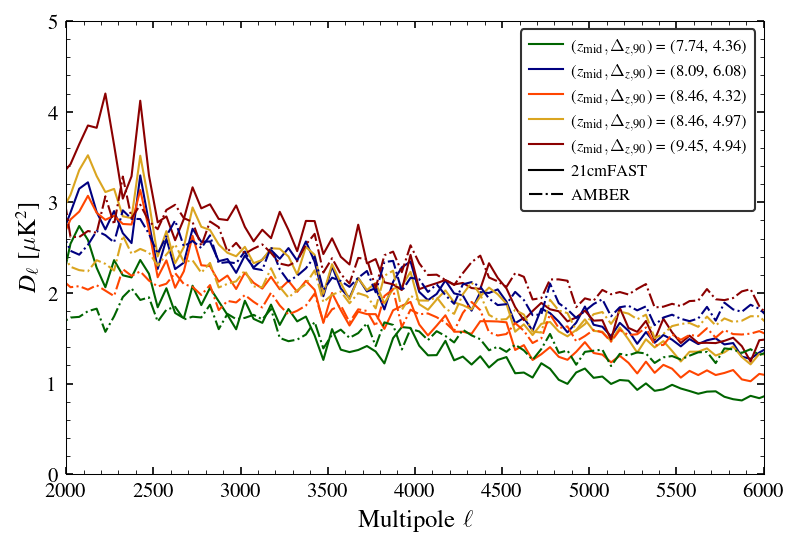

(7.74086, 4.36283)
(8.09399, 6.07768)
(8.46139, 4.32245)
(8.46139, 4.97214)
(9.44614, 4.94372)
(7.74086, 4.36283)
(8.09399, 6.07768)
(8.46139, 4.32245)
(8.46139, 4.97214)
(9.44614, 4.94372)


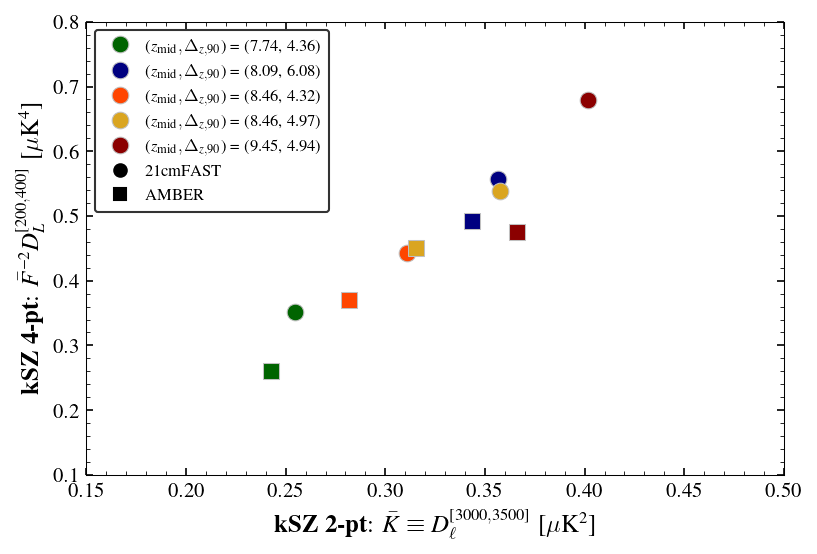

SystemExit: 

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [47]:
#plots
reqd_filter_lmin, reqd_filter_lmax = 3000., 3500.
##reqd_filter_lmin, reqd_filter_lmax = 3500., 4000.
##reqd_filter_lmin, reqd_filter_lmax = 4000., 4500.
##reqd_filter_lmin, reqd_filter_lmax = 4500., 5000.
reqd_filter_lmin_lmax = (reqd_filter_lmin, reqd_filter_lmax)
##reqd_Lmin, reqd_Lmax = 100, 300
reqd_Lmin, reqd_Lmax = 200, 400
##reqd_Lmin, reqd_Lmax = 300, 500

for pl_iter in range(2):
    if pl_iter == 0: #2-pt plot
        xmin, xmax = 2000, 6000.
        ymin, ymax = 0., 5.
    elif pl_iter == 1: #plot 4-pt/fbar**2 vs kbar    
        xmin, xmax = 0.15, 0.5
        ymin, ymax = 0.1, 0.8 #0.5 #None, None

    clf()
    lwval = 1.
    msval = 8.
    fsval = 12
    ax = subplot(111)
    mkr_arr = ['o', 's']
    ls_arr = ['-', '-.']
    color_arr = ['darkgreen', 'navy', 'orangered', 'goldenrod', 'darkred']
    #color_arr = [ cm.Set1(int(d)) for d in np.linspace( 0, 8, len(result_dict) ) ]
    #np.random.shuffle(color_arr)
    for which_ksz_sim_cntr, which_ksz_sim in enumerate( sorted(master_result_dict)):
        result_dict = master_result_dict[which_ksz_sim]
        for kcntr, keyname in enumerate( sorted( result_dict ) ):

            #zre, deltaz
            z_re_val, delta_z_val = keyname
            labval = r'$(z_{\rm mid}, \Delta_{z, 90})$ = (%.2f, %.2f)' %(z_re_val, delta_z_val)
            if which_ksz_sim_cntr == 1:
                labval = None
            print(keyname)

            #get results for some (lmin, lmax)
            big_k_m1_smoothed, el_4pt, cl_big_k_m1, el_2pt, cl_ksz_unfiltered, cl_ksz, kbar, fbar = result_dict[keyname][reqd_filter_lmin_lmax]
            dl_fac_2pt = el_2pt * (el_2pt+1)/2/np.pi
            dl_fac = el_4pt * (el_4pt+1)/2/np.pi
            dl_big_k_m1_prime = dl_fac * cl_big_k_m1 / fbar**2.
            Linds = np.where( (el_4pt>=reqd_Lmin) & (el_4pt<=reqd_Lmax) )[0]
            dl_big_k_m1_prime_mean = np.mean(dl_big_k_m1_prime[Linds])

            if pl_iter == 0: #2-pt plot
                plot(el_2pt, dl_fac_2pt * cl_ksz_unfiltered, ls = ls_arr[which_ksz_sim_cntr], color = color_arr[kcntr], label = labval, lw = lwval)
                
                if (0):##which_ksz_sim == 'amber':
                    tmp_el, tmp_cl_ksz = amber_ksz_2pt_dic[keyname]
                    tmp_dl_fac = tmp_el * (tmp_el+1)/2/np.pi
                    plot(tmp_el, tmp_dl_fac * tmp_cl_ksz, ls = ls_arr[which_ksz_sim_cntr], color = color_arr[kcntr], lw = lwval, alpha = 0.5)
                
            elif pl_iter == 1: #plot 4-pt/fbar**2 vs kbar
                plot(kbar, dl_big_k_m1_prime_mean, marker = mkr_arr[which_ksz_sim_cntr], ls = 'None', ms = msval, mec = 'silver', mew = 0.5, color = color_arr[kcntr], label = labval)

    for which_ksz_sim_cntr, which_ksz_sim in enumerate( sorted(master_result_dict)):
        sim_label = which_ksz_sim_dic[which_ksz_sim]
        if pl_iter == 0: #2-pt plot
            plot([], [], color = 'black', ls = ls_arr[which_ksz_sim_cntr], label = sim_label)
            legend(loc = 1, fontsize = fsval - 4, ncol = 1, columnspacing = 0.5, handletextpad = 0.5, numpoints = 1)
            xlabel(r'Multipole $\ell$', fontsize = fsval)
            ylabel(r'$D_{\ell}$ [$\mu$K${^2}$]', fontsize = fsval)
        elif pl_iter == 1: #plot 4-pt/fbar**2 vs kbar
            plot([], [], color = 'black', marker = mkr_arr[which_ksz_sim_cntr], label = sim_label, ls = 'None')
            legend(loc = 2, fontsize = fsval - 4, ncol = 1, columnspacing = 0.5, handletextpad = 0.5, numpoints = 1)
            xlabel(r'{\bf kSZ 2-pt}: $\bar{K} \equiv D_{\ell}^{[%g, %g]}$ [$\mu$K${^2}$]' %(reqd_filter_lmin, reqd_filter_lmax), fontsize = fsval)
            ylabel(r'{\bf kSZ 4-pt}: $\bar{F}^{-2} D_{L}^{[%g, %g]}$ [$\mu$K${^4}$]' %(reqd_Lmin, reqd_Lmax), fontsize = fsval)

    xlim(xmin, xmax); ylim(ymin, ymax)
    show(); 
sys.exit()

(7.74086, 4.36283)
(8.09399, 6.07768)
(8.46139, 4.32245)
(8.46139, 4.97214)
(9.44614, 4.94372)
(7.74086, 4.36283)
(8.09399, 6.07768)
(8.46139, 4.32245)
(8.46139, 4.97214)
(9.44614, 4.94372)


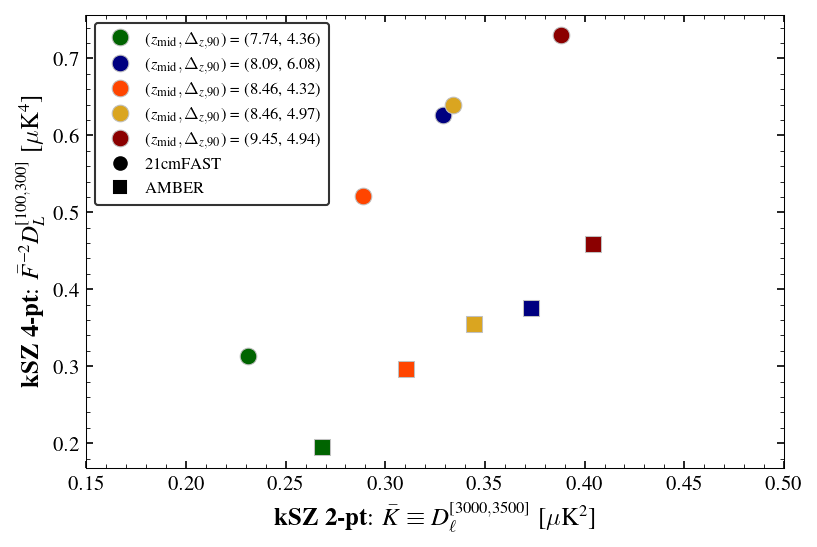

In [13]:
#4-pt vs 2-pt plots
reqd_filter_lmin, reqd_filter_lmax = 3000., 3500.
##reqd_filter_lmin, reqd_filter_lmax = 3500., 4000.
##reqd_filter_lmin, reqd_filter_lmax = 4000., 4500.
##reqd_filter_lmin, reqd_filter_lmax = 4500., 5000.
reqd_filter_lmin_lmax = (reqd_filter_lmin, reqd_filter_lmax)
reqd_Lmin, reqd_Lmax = 100, 300
##reqd_Lmin, reqd_Lmax = 200, 400
##reqd_Lmin, reqd_Lmax = 300, 500

xmin, xmax = 0.15, 0.5
ymin, ymax = 0.1, 0.5 #None, None
clf()
msval = 8.
fsval = 12
ax = subplot(111)
mkr_arr = ['o', 's']
color_arr = ['darkgreen', 'navy', 'orangered', 'goldenrod', 'darkred']
#color_arr = [ cm.Set1(int(d)) for d in np.linspace( 0, 8, len(result_dict) ) ]
#np.random.shuffle(color_arr)
for which_ksz_sim_cntr, which_ksz_sim in enumerate( sorted(master_result_dict)):
    result_dict = master_result_dict[which_ksz_sim]
    for kcntr, keyname in enumerate( sorted( result_dict ) ):

        #zre, deltaz
        z_re_val, delta_z_val = keyname
        labval = r'$(z_{\rm mid}, \Delta_{z, 90})$ = (%.2f, %.2f)' %(z_re_val, delta_z_val)
        if which_ksz_sim_cntr == 1:
            labval = None
        print(keyname)


        #get results for some (lmin, lmax)
        big_k_m1_smoothed, el_4pt, cl_big_k_m1, el_2pt, cl_ksz, kbar, fbar = result_dict[keyname][reqd_filter_lmin_lmax]
        dl_fac = el_4pt * (el_4pt+1)/2/np.pi
        dl_big_k_m1_prime = dl_fac * cl_big_k_m1 / fbar**2.
        Linds = np.where( (el_4pt>=reqd_Lmin) & (el_4pt<=reqd_Lmax) )[0]
        dl_big_k_m1_prime_mean = np.mean(dl_big_k_m1_prime[Linds])

        #plot 4-pt/fbar**2 vs kbar
        plot(kbar, dl_big_k_m1_prime_mean, marker = mkr_arr[which_ksz_sim_cntr], ls = 'None', ms = msval, mec = 'silver', mew = 0.5, color = color_arr[kcntr], label = labval)

for which_ksz_sim_cntr, which_ksz_sim in enumerate( sorted(master_result_dict)):
    sim_label = which_ksz_sim_dic[which_ksz_sim]
    plot([], [], color = 'black', marker = mkr_arr[which_ksz_sim_cntr], label = sim_label, ls = 'None')
        
xlim(xmin, xmax); #ylim(ymin, ymax)
xlabel(r'{\bf kSZ 2-pt}: $\bar{K} \equiv D_{\ell}^{[%g, %g]}$ [$\mu$K${^2}$]' %(reqd_filter_lmin, reqd_filter_lmax), fontsize = fsval)
ylabel(r'{\bf kSZ 4-pt}: $\bar{F}^{-2} D_{L}^{[%g, %g]}$ [$\mu$K${^4}$]' %(reqd_Lmin, reqd_Lmax), fontsize = fsval)
legend(loc = 2, fontsize = fsval - 4, ncol = 1, columnspacing = 0.5, handletextpad = 0.5, numpoints = 1)
show();

In [ ]:
#get map list
if which_ksz_sim == 'amber':
    maplist = sorted( glob.glob( '%s/*%s*/cmb/map_ksz_nside=8192.npy' %(sim_fd, reqd_Az_str)) )
elif which_ksz_sim == '21cmfast':
    if use_flat_sky_maps_for_21cmfast:
        maplist = sorted( glob.glob( '%s/flat_maps_r8907/ksz_flat_map_z_*.dat' %(sim_fd)) )
    else:
        maplist = sorted( glob.glob( '%s/ksz_map_8192_z*.dat' %(sim_fd)) )
print( '\nTotal maps = %s\n' %(len(maplist)) )#; sys.exit()

#loop over map and get the 4-pt
result_dict = {}
for mapname in maplist:

    if which_ksz_sim == 'amber':
        z_re_val = float( re.findall('zre[0-9.0-9]*', mapname)[0].replace('zre', '') )
        delta_z_val = float( re.findall('Dz[0-9.0-9]*', mapname)[0].replace('Dz', '') ) 
    elif which_ksz_sim == '21cmfast':
        maptype_str = re.findall('HII_[0-9]*_BUBBLE_[0-9]*_Tvir_[0-9]*', mapname)[0]
        z_re_val = mapname_zmid_deltaz_mapper_dict[maptype_str]['z_mid']
        delta_z_val = mapname_zmid_deltaz_mapper_dict[maptype_str]['delta_z']
        print( maptype_str, z_re_val, delta_z_val )
    
    keyname = (z_re_val, delta_z_val)
    print( 'z_mid = %s, delta_z_90 = %s' %(z_re_val, delta_z_val) )
    result_dict[keyname] = {}
    ##########################################################################################
    #read map
    if which_ksz_sim == 'amber': #read flatsky map
        tmap = np.load( mapname, allow_pickle = True ) * mask_circular
    elif which_ksz_sim == '21cmfast': #convert healpix to flatsky map
        if use_flat_sky_maps_for_21cmfast:            
            print(mapname); sys.exit()
        else:
            npix = H.nside2npix(nside)
            hmap = np.zeros( npix )
            pix_ind_arr, pix_val_arr = np.loadtxt(mapname, unpack = True)

            npix = H.nside2npix(nside)
            hmap = np.zeros( npix )
            pix_ind_arr, pix_val_arr = np.loadtxt(mapname, unpack = True)
            pix_ind_arr = pix_ind_arr.astype(int)
            hmap[pix_ind_arr] = pix_val_arr * 1e6
            ##H.mollview(hmap); show()

            tmap = H.gnomview(hmap, rot=[ra0, dec0], xsize=boxsize, reso=reso_arcmin, return_projected_map=True); close()
        tmap = np.asarray( tmap ) - np.mean(tmap)
        tmap = tmap * mask
        ##imshow(tmap); colorbar(); show(); sys.exit()
        
    tmap_unfil = np.copy( tmap )
    ##########################################################################################
    ksz_4pt_dict = {}
    for filter_lmin_lmax in filter_lmin_lmax_arr:
        
        lmin_for_filter, lmax_for_filter = filter_lmin_lmax
        print('\t(lmin, lmax) = (%g, %g)' %(lmin_for_filter, lmax_for_filter))

        
        #get filter
        wl_1d, wl_2D = ksz_4pt_flatsky_tools.get_filter(els, lmin_for_filter = lmin_for_filter, lmax_for_filter = lmax_for_filter, mapparams = mapparams)
        '''
        if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2):
            wl2_1d, wl2_2D = ksz_4pt_flatsky_tools.get_filter(els, lmin_for_filter = lmin_for_filter2, lmax_for_filter = lmax_for_filter2, mapparams = mapparams)
        '''

        if show_plot:
            clf()        
            plot(els, wl_1d); xlabel(r'Multipole $\ell$', fontsize = fsval); ylabel(r'Filter $w_{\ell}$', fontsize = fsval); 
            title(r'Filter $\ell \in [%g, %g]$' %(lmin_for_filter, lmax_for_filter), fontsize = fsval)
            show()

            clf()
            axlim = 6000.
            subplot(111); imshow( np.fft.fftshift(wl_2D), extent = [np.min(lx), np.max(lx), np.min(ly), np.max(ly)]); colorbar(); 
            xlabel(r'$\ell_{x}$', fontsize = fsval); ylabel(r'$\ell_{y}$', fontsize = fsval); 
            title(r'Filter $\ell \in [%g, %g]$' %(lmin_for_filter, lmax_for_filter), fontsize = fsval-4)
            xlim(-axlim, axlim); ylim(-axlim, axlim); 
            

        ##########################################################################################
        #filter maps
        tmap1 = np.fft.ifft2( np.fft.fft2( tmap ) * wl_2D ).real
        if (0):##(lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2):
            tmap2 = np.fft.ifft2( np.fft.fft2( tmap ) * w2_2D ).real
        else:
            tmap2 = np.copy( tmap1 )
            
        ##imshow(tmap1); colorbar(); show(); sys.exit()

        #get power spectrum
        el_2pt, cl_m1_unfiltered = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap_unfil, binsize = binsize, maxbin = lmax, mask = mask)
        el_2pt, cl_m1 = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap1, binsize = binsize, maxbin = lmax, mask = mask)

        #get kbar
        fbar = ksz_4pt_flatsky_tools.get_kbar(els, wl_1d)
        tmp_cl_m1_ip = np.interp(els, el_2pt, cl_m1)
        kbar = ksz_4pt_flatsky_tools.get_kbar(els, wl_1d, tmpcls_signal = tmp_cl_m1_ip, filter_only = False)
        if (1):
            tmplinds = np.where( (el_2pt>=lmin_for_filter) & ((el_2pt<=lmax_for_filter)))
            dl_fac = el_2pt * (el_2pt+1)/2/np.pi
            dl_m1 = cl_m1 * dl_fac
            dl_m1_mean = np.mean( dl_m1[tmplinds] )
            print( '\t\t', 'Dl mean = %.2f uk^2; fbar = %.2f; kbar = %.2f uk^2; Dl * fbar = %.2f uk^2' %(dl_m1_mean, fbar, kbar, dl_m1_mean*fbar) );
            ##sys.exit()
                
        if show_plot:


            '''
            if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                el_, cl_m2 = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap2, binsize = binsize, maxbin = lmax, mask = mask_circular)
            '''

            clf()
            ax = subplot(111)#, yscale='log')
            dl_fac = el_ * (el_+1)/2/np.pi
            plot(el_, dl_fac * cl_m1_unfiltered, color = 'gray')
            plot(el_, dl_fac * cl_m1, color = 'black', lw = 4.)
            '''
            if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                plot(el_, dl_fac * cl_m2, color = 'red')
            '''
            xlim(0., 6000.); ylim(0., 5.)
            show(); #sys.exit()

            clf()
            x1,x2, y1, y2 = 500, 1000, 500,1000
            vmin, vmax = -20., 20.
            subplot(121); imshow( tmap_unfil[x1:x2, y1:y2], vmin = vmin, vmax =vmax ); colorbar();  title(r'Unfiltered'); #unfiltered
            subplot(122); imshow( tmap1[x1:x2, y1:y2], vmin = vmin, vmax = vmax ); colorbar();  title(r'Filtered'); #filtered with w1_2D
            show()
            if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                subplot(121); imshow( tmap_unfil[x1:x2, y1:y2], vmin = vmin, vmax = vmax ); colorbar(); title(r'Unfiltered');  #unfiltered
                subplot(122); imshow( tmap2[x1:x2, y1:y2]); colorbar(); title(r'Filtered');  #filtered with w2_2D
                show()
            #sys.exit()                
        ##########################################################################################

        ##########################################################################################
        #get bigK and power spectrum
        big_k_m1, mask_mod, el_4pt, cl_big_k_m1 = ksz_4pt_flatsky_tools.get_4pt_flatsky(tmap1, smap2 = tmap2, mask = mask, angres_am = reso_arcmin)#, add_new_mask_for_big_K = add_new_mask_for_big_K)        

        #smoothed with Gaussian beam
        big_k_m1_smoothed = np.fft.ifft2( np.fft.fft2(big_k_m1) * bl_2D_for_smoothing).real
        
        ksz_4pt_dict[filter_lmin_lmax] = [big_k_m1_smoothed, el_4pt, cl_big_k_m1, el_2pt, cl_m1, kbar, fbar]

        if show_plot:
            subplot(121); imshow( big_k_m1, vmin = 0, vmax =100.); colorbar(); 
            subplot(122); imshow( big_k_m1_smoothed, vmin = -0.5, vmax = 2.5); colorbar(); 
            show()
        
            clf()
            dlfac_str = 'elsq'
            #dlfac_str = 'el'
            if dlfac_str == 'elsq':
                yscaleval = 'log'
                ylabval = r'$L(L+1)\ C_{L}^{KK}/2\pi$ [$\mu$K$^{4}$]'
                ymin, ymax = 1e-4, 1.
                dl_fac = el_4pt * (el_4pt+1)/2/np.pi
            elif dlfac_str == 'el':
                yscaleval = None
                ymin, ymax = -1e-3, 1e-3
                ylabval = r'$L C_{L}^{KK}$ [$\mu$K$^{4}$]'
                dl_fac = el_4pt

            clf()
            ax = subplot(111, yscale = 'log', xscale='log')
            plot(el_4pt, dl_fac * cl_big_k_m1, color = 'black')
            xlim(50., 1000.); ylim(ymin, ymax)
            xlabel(r'Multipole $L$', fontsize = fsval)
            ylabel(ylabval, fontsize = fsval)
            axvspan(100., 400., color = 'orangered', alpha = 0.5)
            show(); sys.exit()     
        ##########################################################################################
    result_dict[keyname] = ksz_4pt_dict
#sys.exit()

In [ ]:
if (0): 
    ra0, dec0 = 0., 90.
    reso_arcmin = 0.5
    #boxsize = 1560
    boxsize = 1560

    npix = H.nside2npix(nside)
    hmap = np.zeros( npix )
    pix_ind_arr, pix_val_arr = np.loadtxt(mapname, unpack = True)
    pix_ind_arr = pix_ind_arr.astype(int)
    hmap[pix_ind_arr] = pix_val_arr * 1e6
    H.mollview(hmap); show()

    curr_smap = H.gnomview(hmap, rot=[ra0, dec0], xsize=boxsize, reso=reso_arcmin, return_projected_map=True); close()
    curr_smap = np.asarray( curr_smap ) - np.mean(curr_smap)
    imshow(curr_smap); colorbar(); show()



In [ ]:
sorted( result_dict.keys() )

In [ ]:
#4-pt vs 2-pt plots
reqd_filter_lmin, reqd_filter_lmax = 3000., 3500.
##reqd_filter_lmin, reqd_filter_lmax = 3500., 4000.
##reqd_filter_lmin, reqd_filter_lmax = 4000., 4500.
##reqd_filter_lmin, reqd_filter_lmax = 4500., 5000.
reqd_filter_lmin_lmax = (reqd_filter_lmin, reqd_filter_lmax)
reqd_Lmin, reqd_Lmax = 100, 300
##reqd_Lmin, reqd_Lmax = 200, 400
##reqd_Lmin, reqd_Lmax = 300, 500

xmin, xmax = 0.15, 0.5
ymin, ymax = 0.1, 0.5 #None, None
clf()
msval = 8.
fsval = 12
ax = subplot(111)
color_arr = ['darkgreen', 'navy', 'orangered', 'goldenrod', 'darkred']
#color_arr = [ cm.Set1(int(d)) for d in np.linspace( 0, 8, len(result_dict) ) ]
#np.random.shuffle(color_arr)
for kcntr, keyname in enumerate( sorted( result_dict ) ):

    #zre, deltaz
    z_re_val, delta_z_val = keyname
    labval = r'$(z_{\rm mid}, \Delta_{z, 90})$ = (%.2f, %.2f)' %(z_re_val, delta_z_val)
    print(keyname)
    
    
    #get results for some (lmin, lmax)
    big_k_m1_smoothed, el_4pt, cl_big_k_m1, el_2pt, cl_ksz, kbar, fbar = result_dict[keyname][reqd_filter_lmin_lmax]
    dl_fac = el_4pt * (el_4pt+1)/2/np.pi
    dl_big_k_m1_prime = dl_fac * cl_big_k_m1 / fbar**2.
    Linds = np.where( (el_4pt>=reqd_Lmin) & (el_4pt<=reqd_Lmax) )[0]
    dl_big_k_m1_prime_mean = np.mean(dl_big_k_m1_prime[Linds])

    #plot 4-pt/fbar**2 vs kbar
    plot(kbar, dl_big_k_m1_prime_mean, marker = 'o', ls = 'None', ms = msval, mec = 'silver', mew = 0.5, color = color_arr[kcntr], label = labval)

xlim(xmin, xmax); #ylim(ymin, ymax)
xlabel(r'{\bf kSZ 2-pt}: $\bar{K} \equiv D_{\ell}^{[%g, %g]}$ [$\mu$K${^2}$]' %(reqd_filter_lmin, reqd_filter_lmax), fontsize = fsval)
ylabel(r'{\bf kSZ 4-pt}: $\bar{F}^{-2} D_{L}^{[%g, %g]}$ [$\mu$K${^4}$]' %(reqd_Lmin, reqd_Lmax), fontsize = fsval)
legend(loc = 'best', fontsize = fsval - 2, ncol = 1, columnspacing = 0.5, handletextpad = 0.5, numpoints = 1)
show();

In [ ]:
#4-pt plots

color_arr = ['navy', 'darkgreen', 'goldenrod', 'orangered', 'darkred']
#dlfac_str = 'elsq'
dlfac_str = 'el'
if dlfac_str == 'elsq':
    scaleval = 'log'
    ylabval = r'$L(L+1)\ C_{L}^{KK}/2\pi$ [$\mu$K$^{4}$]'
    ymin, ymax = 1e-4, 1.
elif dlfac_str == 'el':
    scaleval = None
    #ymin, ymax = -1e-3, 1e-3
    ymin, ymax = -0.5e-2, 2e-2
    ylabval = r'$L C_{L}^{KK}$ [$\mu$K$^{4}$]'

for keyname in sorted( result_dict ):
    z_re_val, delta_z_val = keyname
    print(keyname)
    ksz_4pt_dict = result_dict[keyname]
    title_str = r'AMBER: $z_{\rm mid}$ = %.3f; $\Delta_{z, 90}$ = %.3f' %(z_re_val, delta_z_val)


    clf()
    ax = subplot(111, yscale = scaleval, xscale= scaleval)
    for filter_lmin_lmax_cntr, filter_lmin_lmax in enumerate( sorted(ksz_4pt_dict) ):
        ##print(filter_lmin_lmax_cntr)
        big_k_m1_smoothed, el_4pt, cl_big_k_m1, el_2pt, cl_ksz, kbar, fbar = ksz_4pt_dict[filter_lmin_lmax]
        if dlfac_str == 'elsq':
            dl_fac = el_4pt * (el_4pt+1)/2/np.pi
        elif dlfac_str == 'el':
            dl_fac = el_4pt
        plot(el_4pt, dl_fac * cl_big_k_m1 / fbar**2., color = color_arr[filter_lmin_lmax_cntr], label = r'$\ell \in [%g, %g]$' %(filter_lmin_lmax[0], filter_lmin_lmax[1]))
        #plot(el_4pt, dl_fac * cl_big_k_m1, color = color_arr[filter_lmin_lmax_cntr], ls = '-.')

    xlim(50., 1000.); ylim(ymin, ymax)
    xlabel(r'Multipole $L$', fontsize = fsval)
    ylabel(ylabval, fontsize = fsval)
    legend(loc = 4, fontsize = fsval - 2, ncol = 2, columnspacing = 0.5)
    #axvspan(100., 400., color = 'orangered', alpha = 0.5)
    title(title_str, fontsize = fsval)
    show();     

In [ ]:
#4-pt vs 2-pt plots
#reqd_filter_lmin, reqd_filter_lmax = 3000., 3500.
reqd_filter_lmin_lmax = (reqd_filter_lmin, reqd_filter_lmax)
reqd_Lmin, reqd_Lmax = 100, 300

xmin, xmax = 0.15, 0.5
ymin, ymax = 0.15, 0.5 #None, None
clf()
msval = 8.
fsval = 12
ax = subplot(111)
color_arr = ['navy', 'darkgreen', 'goldenrod', 'orangered', 'darkred']
#color_arr = [ cm.Set1(int(d)) for d in np.linspace( 0, 8, len(result_dict) ) ]
#np.random.shuffle(color_arr)
mkr_arr = ['o', 's', 'd', 'h', 'v']

zre_deltaz_arr_for_plotting = [(7.74086, 4.36283), (8.46139, 4.32245), (8.46139, 4.97214), (8.09399, 6.07768), (9.44614, 4.94372)]

for reqd_filter_lmin_lmax_cntr, reqd_filter_lmin_lmax in enumerate( filter_lmin_lmax_arr ):
    xarr, yarr = [], []
    for kcntr, keyname in enumerate( zre_deltaz_arr_for_plotting ):
        #zre, deltaz
        z_re_val, delta_z_val = keyname
        labval = r'$(z_{\rm mid}, \Delta_{z, 90})$ = (%.2f, %.2f)' %(z_re_val, delta_z_val)
        print(keyname)

        big_k_m1_smoothed, el_4pt, cl_big_k_m1, el_2pt, cl_ksz, kbar, fbar = result_dict[keyname][reqd_filter_lmin_lmax]
        dl_fac = el_4pt * (el_4pt+1)/2/np.pi
        dl_big_k_m1_prime = dl_fac * cl_big_k_m1 / fbar**2.
        Linds = np.where( (el_4pt>=reqd_Lmin) & (el_4pt<=reqd_Lmax) )[0]
        dl_big_k_m1_prime_mean = np.mean(dl_big_k_m1_prime[Linds])
        
        xarr.append(kbar)
        yarr.append( dl_big_k_m1_prime_mean )

    #plot 4-pt/fbar**2 vs kbar
    colorval = color_arr[reqd_filter_lmin_lmax_cntr]
    plot(xarr, yarr, color = colorval, marker = mkr_arr[reqd_filter_lmin_lmax_cntr], ls = '-', ms = msval, mec = 'silver', mew = 0.5)#, label = labval)
xlim(xmin, xmax); #ylim(ymin, ymax)
xlabel(r'{\bf kSZ 2-pt}: $\bar{K} \equiv D_{\ell}^{[%g, %g]}$ [$\mu$K${^2}$]' %(reqd_filter_lmin, reqd_filter_lmax), fontsize = fsval)
ylabel(r'{\bf kSZ 4-pt}: $\bar{F}^{-2} D_{L}^{[%g, %g]}$ [$\mu$K${^4}$]' %(reqd_Lmin, reqd_Lmax), fontsize = fsval)
legend(loc = 2, fontsize = fsval - 2, ncol = 1, columnspacing = 0.5, handletextpad = 0.5, numpoints = 1)
show();